# CISA KVE EPSS Data Analyis 

In [1]:
import pandas as pd
import json
import requests
import os
import glob
import numpy as np

In [2]:
cisa_df = pd.read_csv("https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv")
cisa_df = cisa_df
cisa_df.columns = cisa_df.columns.str.strip("\u200b")
cisa_df = cisa_df.rename(columns={"cveID": "CVE", "shortDescription" : "Description", "vendorProject" : "Vendor", "product" : "Product"})

In [3]:
epss = pd.read_csv('epss_scores-current.csv', skiprows=1)
epss = epss.rename(columns={"cve": "CVE", "epss" : "EPSS", "percentile" : "EPSS Percentile"})

In [4]:
row_accumulator = []
for filename in glob.glob('nvdcve-2.0-*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['vulnerabilities']:
            cve = entry['cve']['id']
            base_score = 0.0
            metrics = entry['cve'].get('metrics', {})
            cvss_v31 = metrics.get('cvssMetricV31', [{}])
            if cvss_v31 and 'cvssData' in cvss_v31[0]:
                base_score = cvss_v31[0]['cvssData'].get('baseScore', 0.0)
            new_row = {
                'CVE': cve,
                'CVSS3': base_score,
            }
            row_accumulator.append(new_row)

# Create DataFrame after all files are processed
nvd = pd.DataFrame(row_accumulator)
nvd['CVSS3'] = pd.to_numeric(nvd['CVSS3'])
nvd['CVSS3'] = nvd['CVSS3'].replace(0, np.nan)

In [5]:
epss_kev = pd.merge(cisa_df, epss, left_on='CVE', right_on='CVE')
epss_kev_nvd =  pd.merge(epss_kev, nvd, left_on='CVE', right_on='CVE')
epss_kev_nvd =  epss_kev_nvd[["CVE", "CVSS3", "EPSS", "EPSS Percentile", "Description", "Vendor", "Product"]]

In [6]:
epss_kev_nvd

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-20362,6.5,0.00840,0.73963,Cisco Secure Firewall Adaptive Security (ASA) ...,Cisco,Secure Firewall Adaptive Security Appliance an...
1,CVE-2025-20333,9.9,0.00975,0.75936,Cisco Secure Firewall Adaptive Security (ASA) ...,Cisco,Secure Firewall Adaptive Security Appliance an...
2,CVE-2025-10585,8.8,0.03830,0.87704,Google Chromium contains a type confusion vuln...,Google,Chromium V8
3,CVE-2025-5086,9.0,0.64220,0.98397,Dassault Systèmes DELMIA Apriso contains a des...,Dassault Systèmes,DELMIA Apriso
4,CVE-2025-38352,7.4,0.00648,0.69943,Linux kernel contains a time-of-check time-of-...,Linux,Kernel
...,...,...,...,...,...,...,...
1412,CVE-2021-27561,9.8,0.94106,0.99904,Yealink Device Management contains a server-si...,Yealink,Device Management
1413,CVE-2021-40539,9.8,0.94424,0.99981,Zoho ManageEngine ADSelfService Plus contains ...,Zoho,ManageEngine
1414,CVE-2020-10189,9.8,0.94248,0.99925,Zoho ManageEngine Desktop Central contains a f...,Zoho,ManageEngine
1415,CVE-2019-8394,6.5,0.87936,0.99449,Zoho ManageEngine ServiceDesk Plus (SDP) conta...,Zoho,ManageEngine


## CISA KEV Score Scatter Plot

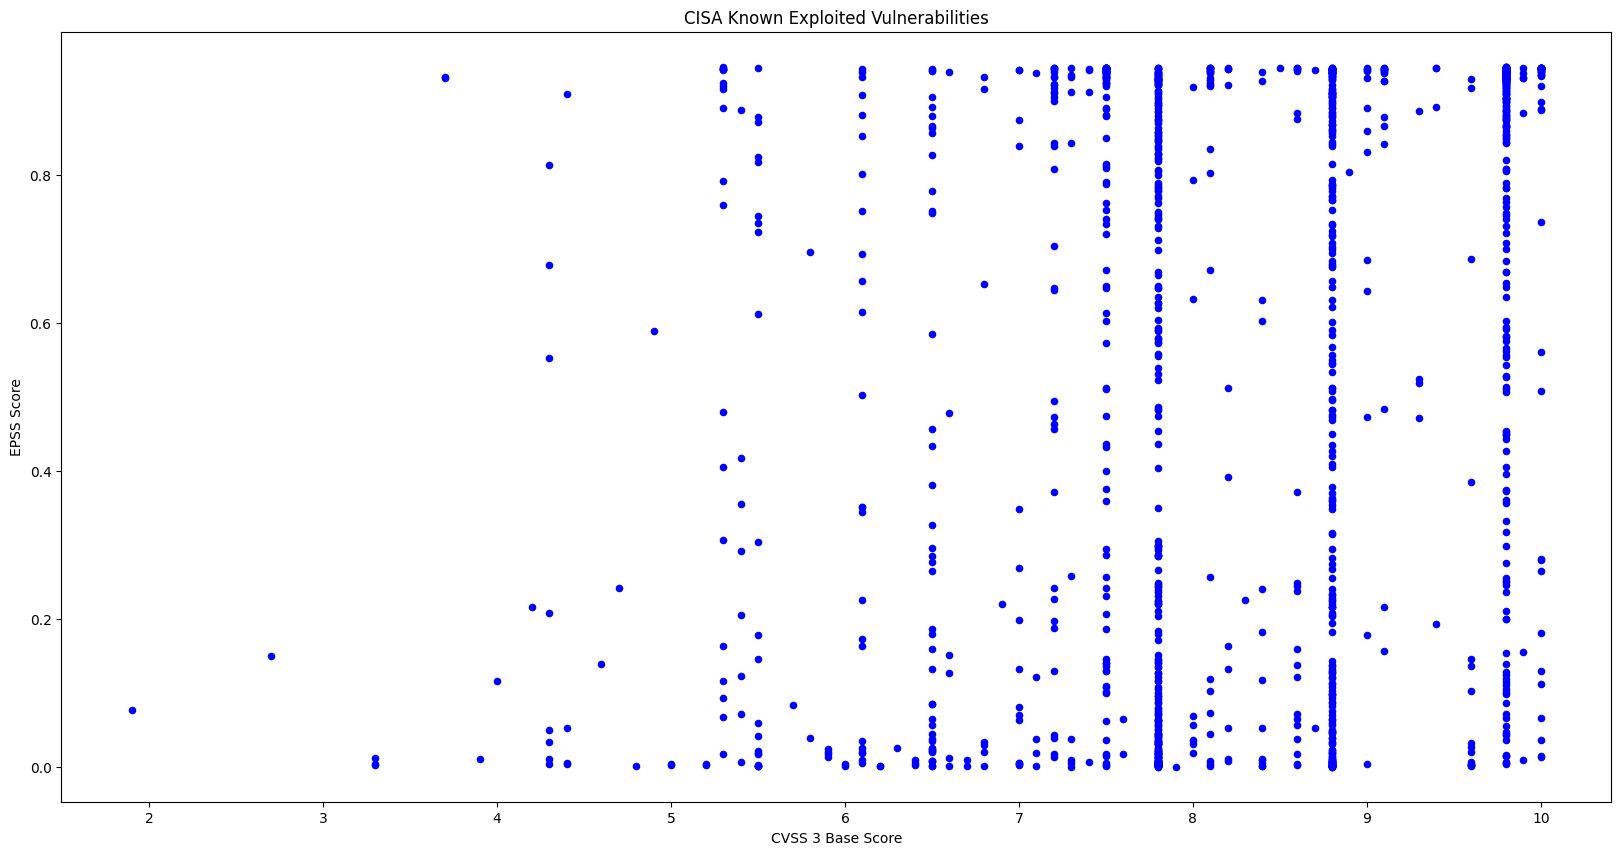

In [7]:
ax = epss_kev_nvd.plot.scatter(x='CVSS3',
                                 y='EPSS',
                                 figsize=(20, 10),
                                 title='CISA Known Exploited Vulnerabilities',
                                 color='blue')
ax.set_xlabel("CVSS 3 Base Score")
ax.set_ylabel("EPSS Score")
ax.get_figure().savefig('epss_kev_nvd.png')

## Export to CVS

In [8]:
epss_kev_nvd.to_csv("epss_kev_nvd.csv", index=False)
epss_kev_nvd.head(10)

,CVE,CVSS3,EPSS,EPSS Percentile,Description,Vendor,Product
0,CVE-2025-20362,6.5,0.00840,0.73963,Cisco Secure Firewall Adaptive Security (ASA) ...,Cisco,Secure Firewall Adaptive Security Appliance an...
1,CVE-2025-20333,9.9,0.00975,0.75936,Cisco Secure Firewall Adaptive Security (ASA) ...,Cisco,Secure Firewall Adaptive Security Appliance an...
2,CVE-2025-10585,8.8,0.03830,0.87704,Google Chromium contains a type confusion vuln...,Google,Chromium V8
3,CVE-2025-5086,9.0,0.64220,0.98397,Dassault Systèmes DELMIA Apriso contains a des...,Dassault Systèmes,DELMIA Apriso
4,CVE-2025-38352,7.4,0.00648,0.69943,Linux kernel contains a time-of-check time-of-...,Linux,Kernel
5,CVE-2025-48543,8.8,0.00085,0.25810,Android Runtime contains a use-after-free vuln...,Android,Runtime
6,CVE-2025-53690,9.0,0.17863,0.94919,"Sitecore Experience Manager (XM), Experience P...",Sitecore,Multiple Products
7,CVE-2023-50224,NaN,0.05729,0.90089,TP-Link TL-WR841N contains an authentication b...,TP-Link,TL-WR841N
8,CVE-2025-9377,7.2,0.18741,0.95069,TP-Link Archer C7(EU) and TL-WR841N/ND(MS) con...,TP-Link,Multiple Routers
9,CVE-2020-24363,8.8,0.26780,0.96194,TP-link TL-WA855RE contains a missing authenti...,TP-Link,TL-WA855RE
